In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
import joblib

class FeaturePreprocessor(BaseEstimator, TransformerMixin):
    AVAILABLE_TS_FEATURES = {
        'borrow_timestamp':{'day', 'dayofyear', 'week'},
        'first_tx_timestamp':{'day','dayofweek','dayofyear','hour','hour_cos','hour_sin','minute','second','week'},
        'last_tx_timestamp':{'week', 'dayofyear'},
        'risky_first_tx_timestamp':{'day','dayofweek','dayofyear','hour','hour_cos','hour_sin','minute','second','week'},
        'risky_last_tx_timestamp':{'dayofyear'},
    }

    def __init__(self,
                 timestamp_columns=None,
                 timestamp_features=None,
                 numeric_columns=None,
                 quantile_output_distribution='uniform',
                 quantile_n_quantiles=1000,
                 random_state=42):
        self.timestamp_columns = timestamp_columns or []
        self.timestamp_features = timestamp_features if timestamp_features else self.AVAILABLE_TS_FEATURES
        self.numeric_columns = numeric_columns
        self.quantile_output_distribution = quantile_output_distribution
        self.quantile_n_quantiles = quantile_n_quantiles
        self.random_state = random_state

        self.quantile_transformers = {}

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        # Определим числовые колонки, исключая timestamp
        if self.numeric_columns is None:
            self.numeric_columns_ = X.select_dtypes(include=[np.number]).columns.difference(self.timestamp_columns).tolist()
        else:
            self.numeric_columns_ = [col for col in self.numeric_columns if col not in self.timestamp_columns]

        # Обучим QuantileTransformer по числовым колонкам
        for col in self.numeric_columns_:
            qt = QuantileTransformer(
                output_distribution=self.quantile_output_distribution,
                n_quantiles=min(self.quantile_n_quantiles, X.shape[0]),
                random_state=self.random_state
            )
            qt.fit(X[[col]])
            self.quantile_transformers[col] = qt

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        result = pd.DataFrame(index=X.index)

        # Преобразуем числовые признаки
        for col in self.numeric_columns_:
            qt = self.quantile_transformers.get(col)
            if qt:
                result[f'{col}_qt'] = qt.transform(X[[col]]).flatten()

        # Временные признаки
        for col in self.timestamp_columns:
            ts = pd.to_datetime(X[col], unit='s')
            prefix = col
            temp = {}

            # Сначала извлечём все timestamp признаки
            if 'day' in self.timestamp_features[col]:
                temp[f'{prefix}_day'] = ts.dt.day
            if 'dayofweek' in self.timestamp_features[col]:
                temp[f'{prefix}_dayofweek'] = ts.dt.dayofweek
            if 'dayofyear' in self.timestamp_features[col]:
                temp[f'{prefix}_dayofyear'] = ts.dt.dayofyear
            if 'week' in self.timestamp_features[col]:
                temp[f'{prefix}_week'] = ts.dt.isocalendar().week
            if 'hour' in self.timestamp_features[col]:
                temp[f'{prefix}_hour'] = ts.dt.hour
            if 'minute' in self.timestamp_features[col]:
                temp[f'{prefix}_minute'] = ts.dt.minute
            if 'second' in self.timestamp_features[col]:
                temp[f'{prefix}_second'] = ts.dt.second
            if 'hour_sin' in self.timestamp_features[col]:
                temp[f'{prefix}_hour_sin'] = np.sin(2 * np.pi * ts.dt.hour / 24)
            if 'hour_cos' in self.timestamp_features[col]:
                temp[f'{prefix}_hour_cos'] = np.cos(2 * np.pi * ts.dt.hour / 24)
            temp_df = pd.DataFrame(temp)
            result = pd.concat([result, temp_df], axis=1)

        return result

    def save(self, path: str):
        joblib.dump(self, path)

    @staticmethod
    def load(path: str):
        return joblib.load(path)

timestamp_columns = ['borrow_timestamp',
                     'first_tx_timestamp',
                     'last_tx_timestamp',
                     'risky_first_tx_timestamp',
                     'risky_last_tx_timestamp'
                    ]
numeric_columns = ['repay_amount_sum_eth']
feature_preproc = FeaturePreprocessor(timestamp_columns=timestamp_columns, numeric_columns=numeric_columns)

# Загрузка данных

In [2]:
raw_data = pd.read_parquet("..\\Data\\raw\\dataset.parquet")

In [3]:
origin_columns = [
    'repay_amount_sum_eth',
    'risk_factor',
    'max_risk_factor',
    'avg_risk_factor',
    'total_available_borrows_avg_eth',
    'time_since_first_deposit',
    'borrow_block_number',
    'risk_factor_above_threshold_daily_count',
    'market_atr',
    'borrow_count',
    'wallet_age',
    'borrow_amount_avg_eth',
    'repay_count',
    'min_eth_ever',
    'deposit_amount_sum_eth',
    'total_available_borrows_eth',
    'incoming_tx_avg_eth',
    'avg_weighted_risk_factor',
    'total_collateral_avg_eth',
    'withdraw_amount_sum_eth',
    'market_natr',
    'market_adxr',
    'risky_first_tx_timestamp',
    'risky_tx_count',
    'outgoing_tx_count',
    'incoming_tx_count',
    'risky_sum_outgoing_amount_eth',
    'market_aroonosc',
    'risky_unique_contract_count',
    'market_macdsignal_macdfix',
    'max_eth_ever',
    'deposit_count',
    'total_balance_eth',
    'time_since_last_liquidated',
    'market_plus_dm',
    'repay_amount_avg_eth',
    'first_tx_timestamp',
    'total_collateral_eth',
    'total_gas_paid_eth',
    'risky_first_last_tx_timestamp_diff',
    'borrow_repay_diff_eth',
    'liquidation_amount_sum_eth',
    'outgoing_tx_sum_eth',
    'outgoing_tx_avg_eth',
    'liquidation_count',
    'incoming_tx_sum_eth',
    'market_macd_macdfix',
    'borrow_amount_sum_eth',
    'market_apo',
    'market_linearreg_slope',
    'withdraw_deposit_diff_if_positive_eth',
    'market_cmo',
    'unique_lending_protocol_count',
    'market_macdsignal_macdext',
    'unique_borrow_protocol_count',
    'market_adx',
    'market_cci',
    'market_fastk',
    # 'target',
]

# Разбивка на тест и трейн

In [4]:
X_selected = raw_data.drop(columns=['target'])
y = raw_data['target']

In [5]:
from sklearn.model_selection import train_test_split

# Сначала train+val и test
X_temp, X_test, y_temp, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Потом train и val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# В итоге: 60% train, 20% val, 20% test

In [22]:
print(len(X_train),len(X_val),len(X_test))

265776 88592 88593


In [6]:
feature_preproc.fit(X_train)

FeaturePreprocessor(numeric_columns=['repay_amount_sum_eth'],
                    timestamp_columns=['borrow_timestamp', 'first_tx_timestamp',
                                       'last_tx_timestamp',
                                       'risky_first_tx_timestamp',
                                       'risky_last_tx_timestamp'],
                    timestamp_features={'borrow_timestamp': {'day', 'dayofyear',
                                                             'week'},
                                        'first_tx_timestamp': {'day',
                                                               'dayofweek',
                                                               'dayofyear',
                                                               'hour',
                                                               'hour_cos',
                                                               'hour_sin',
                                                               'minute',
                                                               'second',
                                                               'week'},
                                        'last_tx_timestamp': {'dayofyear',
                                                              'week'},
                                        'risky_first_tx_timestamp': {'day',
                                                                     'dayofweek',
                                                                     'dayofyear',
                                                                     'hour',
                                                                     'hour_cos',
                                                                     'hour_sin',
                                                                     'minute',
                                                                     'second',
                                                                     'week'},
                                        'risky_last_tx_timestamp': {'dayofyear'}})

In [7]:
X_train = pd.concat([X_train , feature_preproc.transform(X_train)], axis=1)[origin_columns]
X_test = pd.concat([X_test , feature_preproc.transform(X_test)], axis=1)[origin_columns]
X_val = pd.concat([X_val , feature_preproc.transform(X_val)], axis=1)[origin_columns]
X_val

,repay_amount_sum_eth,risk_factor,max_risk_factor,avg_risk_factor,total_available_borrows_avg_eth,time_since_first_deposit,borrow_block_number,risk_factor_above_threshold_daily_count,market_atr,borrow_count,...,market_apo,market_linearreg_slope,withdraw_deposit_diff_if_positive_eth,market_cmo,unique_lending_protocol_count,market_macdsignal_macdext,unique_borrow_protocol_count,market_adx,market_cci,market_fastk
186922,292.153216,0.649919,0.950613,0.781117,151.830396,24869419.0,12399932,1453.0,132.071331,51,...,434.065874,106.437114,0.0,62.029609,2,267.458249,1,42.874293,131.038927,93.824285
44510,20.078288,0.000001,0.000001,0.000001,22.862581,548424.0,10338390,0.0,10.381967,3,...,-4.119332,0.091180,0.0,1.375545,1,0.012757,1,18.512297,-17.169513,22.240748
38282,0.000000,0.800000,0.000001,0.000001,102.339162,24692.0,10299602,0.0,10.521174,1,...,3.052136,-1.336190,0.0,-4.453839,1,10.536629,1,22.677530,-113.345502,38.914461
111464,47.889048,0.843087,0.881435,0.700986,23.387554,2118107.0,11631130,86.0,39.034632,17,...,203.225461,52.862327,0.0,73.852237,1,122.271190,1,49.180392,97.731219,69.798508
260641,1.359394,0.829683,0.944524,0.763232,2.338779,3324997.0,13137788,34.0,191.625746,15,...,62.159366,10.906993,0.0,28.678423,1,118.162873,1,22.023247,174.620761,91.736910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240557,246239.075730,0.445265,0.700312,0.473283,344225.184542,5166865.0,12902506,0.0,193.065938,34,...,-106.204905,15.085507,0.0,11.810266,2,-90.359907,2,17.644453,142.568562,98.569252
191519,0.000000,0.607752,0.655860,0.573593,0.946916,2016726.0,12449047,0.0,160.349726,2,...,580.126510,33.332814,0.0,14.329228,1,560.722907,1,50.868486,-26.988375,23.388837
18244,0.000000,0.702846,0.957311,0.789646,1.613442,8904537.0,9220061,35.0,8.181268,4,...,-3.116851,0.331167,0.0,-1.248511,1,-6.545843,1,32.298578,145.786972,89.716787
354082,27436.895126,0.821209,0.946613,0.745872,4324.679499,5006232.0,15264686,795.0,134.516191,38,...,177.159302,13.976317,0.0,19.839848,2,185.422103,1,29.444766,51.190761,17.968189


# Обучение нескольких классификаторов

In [8]:
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
}

results = {'val':{},'test':{}}

for name, model in models.items():
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    results['val'][name] = {
        "roc_auc": roc_auc_score(y_val, y_proba),
        "report": classification_report(y_val, y_pred, output_dict=True)
    }
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results['test'][name] = {
        "roc_auc": roc_auc_score(y_test, y_proba),
        "report": classification_report(y_test, y_pred, output_dict=True)
    }

LogisticRegression
RandomForest
LightGBM
XGBoost
CatBoost


# Сравнение моделей

## Val

In [9]:
pd.DataFrame({
    model: {
        "ROC AUC": res["roc_auc"],
        "F1": res["report"]["weighted avg"]["f1-score"],
        "Precision": res["report"]["weighted avg"]["precision"],
        "Recall": res["report"]["weighted avg"]["recall"]
    }
    for model, res in results['val'].items()
}).T.sort_values("ROC AUC", ascending=False)

,ROC AUC,F1,Precision,Recall
RandomForest,0.949854,0.885727,0.890659,0.888037
CatBoost,0.919173,0.848401,0.853071,0.851759
XGBoost,0.915299,0.845177,0.849580,0.848553
LightGBM,0.897061,0.826143,0.831944,0.830707
LogisticRegression,0.669107,0.651167,0.712692,0.696429


## Test

In [10]:
pd.DataFrame({
    model: {
        "ROC AUC": res["roc_auc"],
        "F1": res["report"]["weighted avg"]["f1-score"],
        "Precision": res["report"]["weighted avg"]["precision"],
        "Recall": res["report"]["weighted avg"]["recall"]
    }
    for model, res in results['test'].items()
}).T.sort_values("ROC AUC", ascending=False)

,ROC AUC,F1,Precision,Recall
RandomForest,0.951023,0.887522,0.892523,0.889799
CatBoost,0.920073,0.850978,0.855950,0.854345
XGBoost,0.915753,0.846754,0.851157,0.850078
LightGBM,0.897967,0.828588,0.834436,0.833068
LogisticRegression,0.664276,0.649223,0.709735,0.694716


RandomForest оказался победителем на валидации и тесте, но будем подбираться параметры под CatBoost <br>
Он не сильно хуже конкурента, но его можно обучать на GPU

# Подбор гиперпараметров с Optuna

In [11]:
from catboost import CatBoostClassifier, Pool

In [11]:
import optuna

# from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5, log=True),
        'depth': trial.suggest_int('depth', 8, 14),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 8),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 200),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'eval_metric': 'F1',
        'loss_function': 'Logloss',
        'random_seed': 42,
        'verbose': False,               # Отключаем лог
        'allow_writing_files': False,  # Не писать лишние файлы
        'early_stopping_rounds': 30,
        'task_type': 'GPU'
    }

    train_pool = Pool(X_train, y_train)
    valid_pool = Pool(X_val, y_val)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True, plot=False)  # ⬅️ включаем график

    y_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_proba)

    print(f"[Trial {trial.number}] ROC AUC: {score:.5f}")
    return score

study = optuna.create_study(direction='maximize')

[I 2025-07-23 20:17:52,879] A new study created in memory with name: no-name-af88a4b8-e7a9-4900-9c3d-91b353f7627d


In [12]:
study.optimize(objective, n_trials=20)

[I 2025-07-23 20:19:23,564] Trial 0 finished with value: 0.9521503260872022 and parameters: {'learning_rate': 0.24986109104908058, 'depth': 13, 'l2_leaf_reg': 5.577611967245386, 'bagging_temperature': 0.4534089401000465, 'border_count': 78, 'random_strength': 1.9512373077737872}. Best is trial 0 with value: 0.9521503260872022.


[Trial 0] ROC AUC: 0.95215


[I 2025-07-23 20:19:46,046] Trial 1 finished with value: 0.9489728612930195 and parameters: {'learning_rate': 0.20115691260996435, 'depth': 10, 'l2_leaf_reg': 5.730575559255946, 'bagging_temperature': 0.32426345202570916, 'border_count': 182, 'random_strength': 0.36897862810561544}. Best is trial 0 with value: 0.9521503260872022.


[Trial 1] ROC AUC: 0.94897


[I 2025-07-23 20:20:24,373] Trial 2 finished with value: 0.9506001400684455 and parameters: {'learning_rate': 0.1980262952526284, 'depth': 11, 'l2_leaf_reg': 1.4437364640456969, 'bagging_temperature': 0.7401948169829412, 'border_count': 168, 'random_strength': 1.0991361991437052}. Best is trial 0 with value: 0.9521503260872022.


[Trial 2] ROC AUC: 0.95060


[I 2025-07-23 20:20:50,202] Trial 3 finished with value: 0.9485912792413642 and parameters: {'learning_rate': 0.13875462586940326, 'depth': 10, 'l2_leaf_reg': 4.826646643551521, 'bagging_temperature': 0.6625282457703687, 'border_count': 152, 'random_strength': 0.4226540047143069}. Best is trial 0 with value: 0.9521503260872022.


[Trial 3] ROC AUC: 0.94859


[I 2025-07-23 20:21:07,645] Trial 4 finished with value: 0.9455833415511692 and parameters: {'learning_rate': 0.20928577369668908, 'depth': 9, 'l2_leaf_reg': 4.446164697405894, 'bagging_temperature': 0.5711975437451661, 'border_count': 193, 'random_strength': 1.760706147519821}. Best is trial 0 with value: 0.9521503260872022.


[Trial 4] ROC AUC: 0.94558


[I 2025-07-23 20:21:45,433] Trial 5 finished with value: 0.9512529900530272 and parameters: {'learning_rate': 0.1073877290126772, 'depth': 11, 'l2_leaf_reg': 4.0151749101488905, 'bagging_temperature': 0.45453731546890985, 'border_count': 97, 'random_strength': 1.1046932423872449}. Best is trial 0 with value: 0.9521503260872022.


[Trial 5] ROC AUC: 0.95125


[I 2025-07-23 20:22:22,227] Trial 6 finished with value: 0.9498822148250106 and parameters: {'learning_rate': 0.241272897829852, 'depth': 11, 'l2_leaf_reg': 2.5054645649086944, 'bagging_temperature': 0.9154746741902758, 'border_count': 187, 'random_strength': 1.6294971421837217}. Best is trial 0 with value: 0.9521503260872022.


[Trial 6] ROC AUC: 0.94988


[I 2025-07-23 20:22:32,077] Trial 7 finished with value: 0.940093734308934 and parameters: {'learning_rate': 0.4046981719873931, 'depth': 8, 'l2_leaf_reg': 6.7885473875454005, 'bagging_temperature': 0.7157378087363964, 'border_count': 64, 'random_strength': 1.7891759605714888}. Best is trial 0 with value: 0.9521503260872022.


[Trial 7] ROC AUC: 0.94009


[I 2025-07-23 20:23:30,779] Trial 8 finished with value: 0.9472035903267986 and parameters: {'learning_rate': 0.2888605312392207, 'depth': 13, 'l2_leaf_reg': 1.052625123960891, 'bagging_temperature': 0.9985702908629511, 'border_count': 172, 'random_strength': 0.17190432561786068}. Best is trial 0 with value: 0.9521503260872022.


[Trial 8] ROC AUC: 0.94720


[I 2025-07-23 20:24:58,236] Trial 9 finished with value: 0.9515403721727385 and parameters: {'learning_rate': 0.2007399118118646, 'depth': 14, 'l2_leaf_reg': 6.8301421343139985, 'bagging_temperature': 0.08441051602089278, 'border_count': 35, 'random_strength': 1.910297825124088}. Best is trial 0 with value: 0.9521503260872022.


[Trial 9] ROC AUC: 0.95154


[I 2025-07-23 20:25:50,115] Trial 10 finished with value: 0.947180245042384 and parameters: {'learning_rate': 0.480829226210439, 'depth': 13, 'l2_leaf_reg': 7.86377097563724, 'bagging_temperature': 0.21471692236955386, 'border_count': 116, 'random_strength': 1.4108359817372147}. Best is trial 0 with value: 0.9521503260872022.


[Trial 10] ROC AUC: 0.94718


[I 2025-07-23 20:27:26,888] Trial 11 finished with value: 0.9508647837300418 and parameters: {'learning_rate': 0.31115348925369496, 'depth': 14, 'l2_leaf_reg': 6.491915830165136, 'bagging_temperature': 0.0015661912398847455, 'border_count': 39, 'random_strength': 1.9998038939727534}. Best is trial 0 with value: 0.9521503260872022.


[Trial 11] ROC AUC: 0.95086


[I 2025-07-23 20:29:58,385] Trial 12 finished with value: 0.9541601250085004 and parameters: {'learning_rate': 0.15092962689327066, 'depth': 14, 'l2_leaf_reg': 7.84569120119251, 'bagging_temperature': 0.04434348211669768, 'border_count': 32, 'random_strength': 1.426672091024717}. Best is trial 12 with value: 0.9541601250085004.


[Trial 12] ROC AUC: 0.95416


[I 2025-07-23 20:31:28,279] Trial 13 finished with value: 0.9537006458088428 and parameters: {'learning_rate': 0.14334470976288696, 'depth': 13, 'l2_leaf_reg': 7.4317645200385645, 'bagging_temperature': 0.361112617466379, 'border_count': 72, 'random_strength': 1.3927700336883488}. Best is trial 12 with value: 0.9541601250085004.


[Trial 13] ROC AUC: 0.95370


[I 2025-07-23 20:32:23,673] Trial 14 finished with value: 0.953913152411374 and parameters: {'learning_rate': 0.1464273459433191, 'depth': 12, 'l2_leaf_reg': 7.464149350527485, 'bagging_temperature': 0.22833680898094627, 'border_count': 59, 'random_strength': 1.379566884527934}. Best is trial 12 with value: 0.9541601250085004.


[Trial 14] ROC AUC: 0.95391


[I 2025-07-23 20:33:19,421] Trial 15 finished with value: 0.9535822404916161 and parameters: {'learning_rate': 0.15442454930209004, 'depth': 12, 'l2_leaf_reg': 7.842968610375479, 'bagging_temperature': 0.17971583682332115, 'border_count': 52, 'random_strength': 0.8227267827343239}. Best is trial 12 with value: 0.9541601250085004.


[Trial 15] ROC AUC: 0.95358


[I 2025-07-23 20:34:19,547] Trial 16 finished with value: 0.9529846842585745 and parameters: {'learning_rate': 0.10018666025611955, 'depth': 12, 'l2_leaf_reg': 3.413688091699166, 'bagging_temperature': 0.16888409267735638, 'border_count': 97, 'random_strength': 1.3974802730896945}. Best is trial 12 with value: 0.9541601250085004.


[Trial 16] ROC AUC: 0.95298


[I 2025-07-23 20:36:53,992] Trial 17 finished with value: 0.9533075310682022 and parameters: {'learning_rate': 0.16406590465746632, 'depth': 14, 'l2_leaf_reg': 5.851436701430477, 'bagging_temperature': 0.011743267571378932, 'border_count': 135, 'random_strength': 0.875845261172494}. Best is trial 12 with value: 0.9541601250085004.


[Trial 17] ROC AUC: 0.95331


[I 2025-07-23 20:37:32,029] Trial 18 finished with value: 0.9510685208365183 and parameters: {'learning_rate': 0.12494550379654415, 'depth': 12, 'l2_leaf_reg': 7.307979449203373, 'bagging_temperature': 0.2875517400693192, 'border_count': 52, 'random_strength': 1.250771358358956}. Best is trial 12 with value: 0.9541601250085004.


[Trial 18] ROC AUC: 0.95107


[I 2025-07-23 20:38:25,881] Trial 19 finished with value: 0.9530323390099881 and parameters: {'learning_rate': 0.16862479524737853, 'depth': 12, 'l2_leaf_reg': 6.2770150004989596, 'bagging_temperature': 0.10907101564916499, 'border_count': 96, 'random_strength': 1.562553973275029}. Best is trial 12 with value: 0.9541601250085004.


[Trial 19] ROC AUC: 0.95303


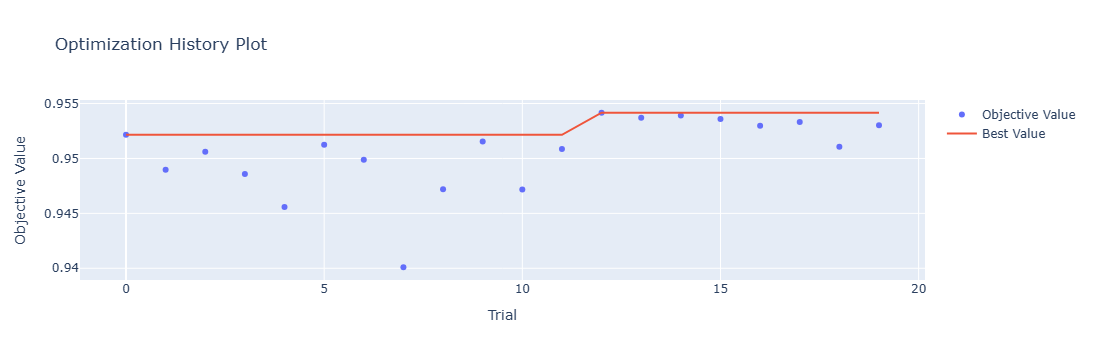

In [13]:
import optuna.visualization as vis

vis.plot_optimization_history(study)

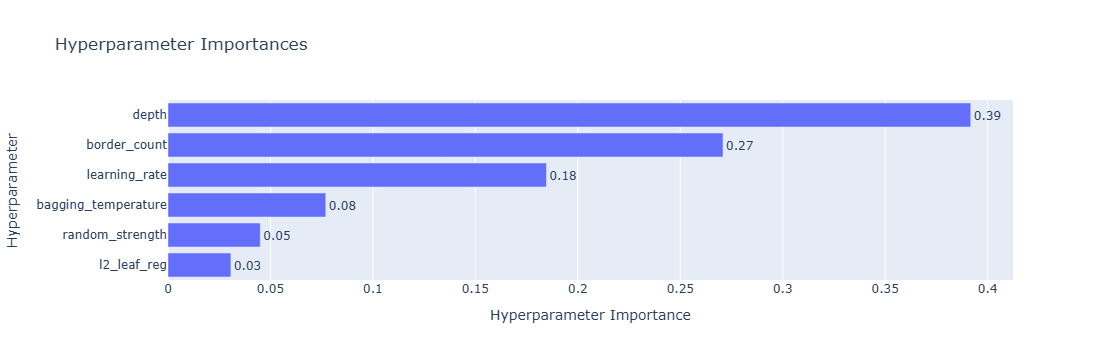

In [14]:
vis.plot_param_importances(study)

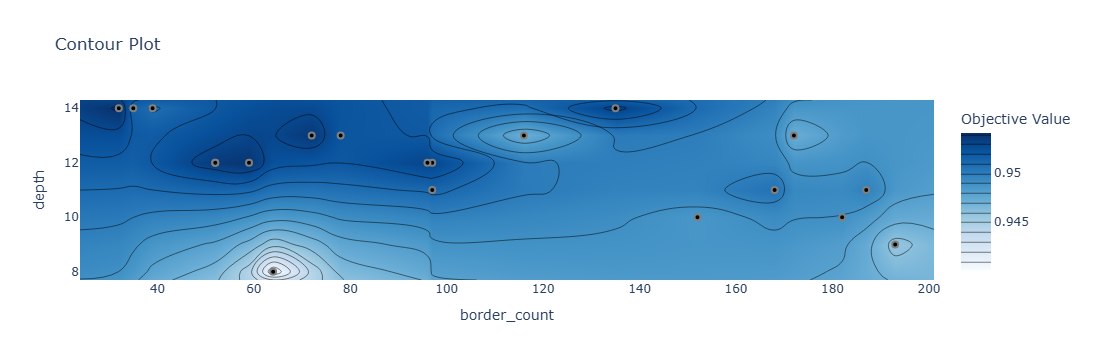

In [16]:
vis.plot_contour(study, params=["border_count", "depth"])

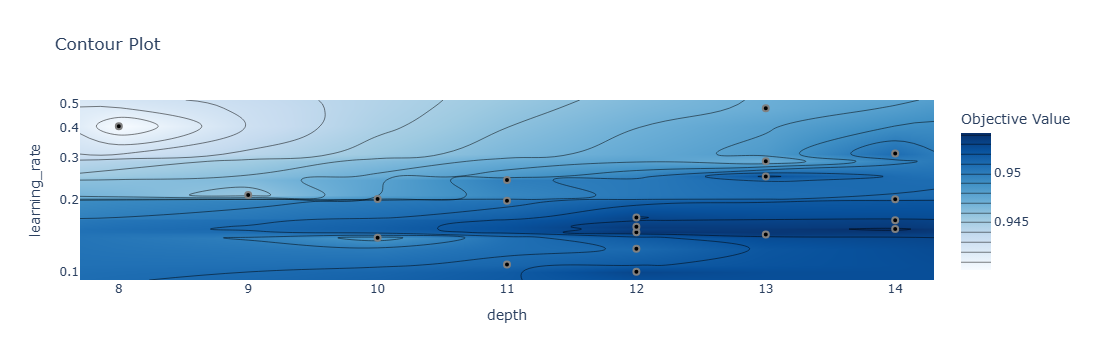

In [15]:
vis.plot_contour(study, params=["learning_rate", "depth"])

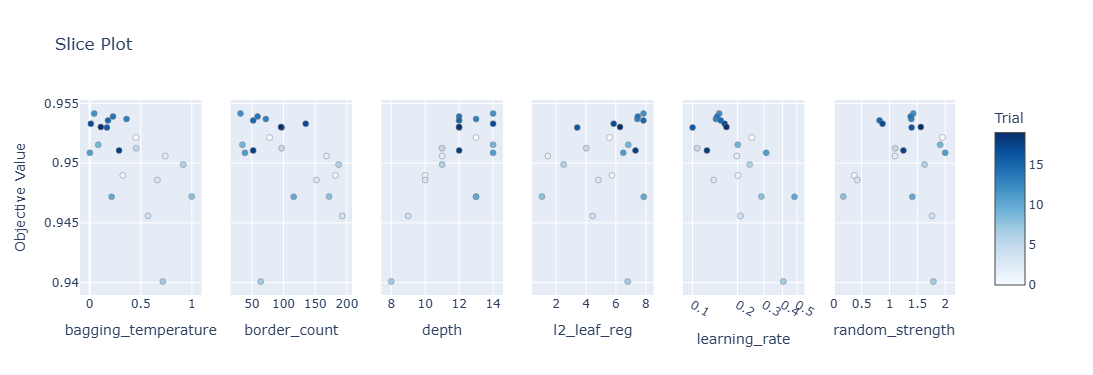

In [17]:
vis.plot_slice(study)

In [18]:
best_params = study.best_params
best_params

{'learning_rate': 0.15092962689327066,
 'depth': 14,
 'l2_leaf_reg': 7.84569120119251,
 'bagging_temperature': 0.04434348211669768,
 'border_count': 32,
 'random_strength': 1.426672091024717}

In [9]:
best_params = {'learning_rate': 0.151,
 'depth': 14,
 'l2_leaf_reg': 7.8457,
 'bagging_temperature': 0.0443,
 'border_count': 32,
 'random_strength': 1.4266}

In [12]:
best_model = CatBoostClassifier(
    iterations=1000,
    eval_metric='F1',
    loss_function='Logloss',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=False,
    allow_writing_files=False,
    task_type='GPU',
    **best_params
)

best_model.fit(Pool(X_train, y_train), eval_set=Pool(X_val, y_val), use_best_model=True, plot=False)

In [13]:
results = {'val':{},'test':{}}
y_pred = best_model.predict(Pool(X_val, y_val))
y_proba = best_model.predict_proba(Pool(X_val, y_val))[:, 1]
results['val']['CatBoost'] = {
        "roc_auc": roc_auc_score(y_val, y_proba),
        "report": classification_report(y_val, y_pred, output_dict=True)
    }
y_pred = best_model.predict(Pool(X_test, y_test))
y_proba = best_model.predict_proba(Pool(X_test, y_test))[:, 1]
results['test']['CatBoost'] = {
        "roc_auc": roc_auc_score(y_test, y_proba),
        "report": classification_report(y_test, y_pred, output_dict=True)
    }

In [14]:
pd.DataFrame({
    model: {
        "ROC AUC": res["roc_auc"],
        "F1": res["report"]["weighted avg"]["f1-score"],
        "Precision": res["report"]["weighted avg"]["precision"],
        "Recall": res["report"]["weighted avg"]["recall"]
    }
    for model, res in results['val'].items()
}).T.sort_values("ROC AUC", ascending=False)

,ROC AUC,F1,Precision,Recall
CatBoost,0.951561,0.89049,0.893523,0.892225


In [15]:
pd.DataFrame({
    model: {
        "ROC AUC": res["roc_auc"],
        "F1": res["report"]["weighted avg"]["f1-score"],
        "Precision": res["report"]["weighted avg"]["precision"],
        "Recall": res["report"]["weighted avg"]["recall"]
    }
    for model, res in results['val'].items()
}).T.sort_values("ROC AUC", ascending=False)

,ROC AUC,F1,Precision,Recall
CatBoost,0.951561,0.89049,0.893523,0.892225


In [16]:
# Получение важностей признаков
importances = best_model.get_feature_importance()

# Преобразование в DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_importance_df

,feature,importance
0,min_eth_ever,6.267908
1,max_risk_factor,5.524406
2,risk_factor,5.283406
3,time_since_first_deposit,4.783410
4,wallet_age,4.326189
5,total_balance_eth,3.998918
6,avg_risk_factor,3.564586
7,market_aroonosc,3.343320
8,market_adxr,3.154665
9,market_atr,2.778884


🔍 Вычисляем SHAP для CatBoost...
Processing trees...
128/469 trees processed	passed time: 84us	remaining time: 224us
256/469 trees processed	passed time: 142us	remaining time: 118us
384/469 trees processed	passed time: 182us	remaining time: 40us
469/469 trees processed	passed time: 243us	remaining time: 0us
Processing documents...
128/500 documents processed	passed time: 2m 7s	remaining time: 6m 11s
256/500 documents processed	passed time: 4m 12s	remaining time: 4m
384/500 documents processed	passed time: 6m 16s	remaining time: 1m 53s
500/500 documents processed	passed time: 8m 5s	remaining time: 0us


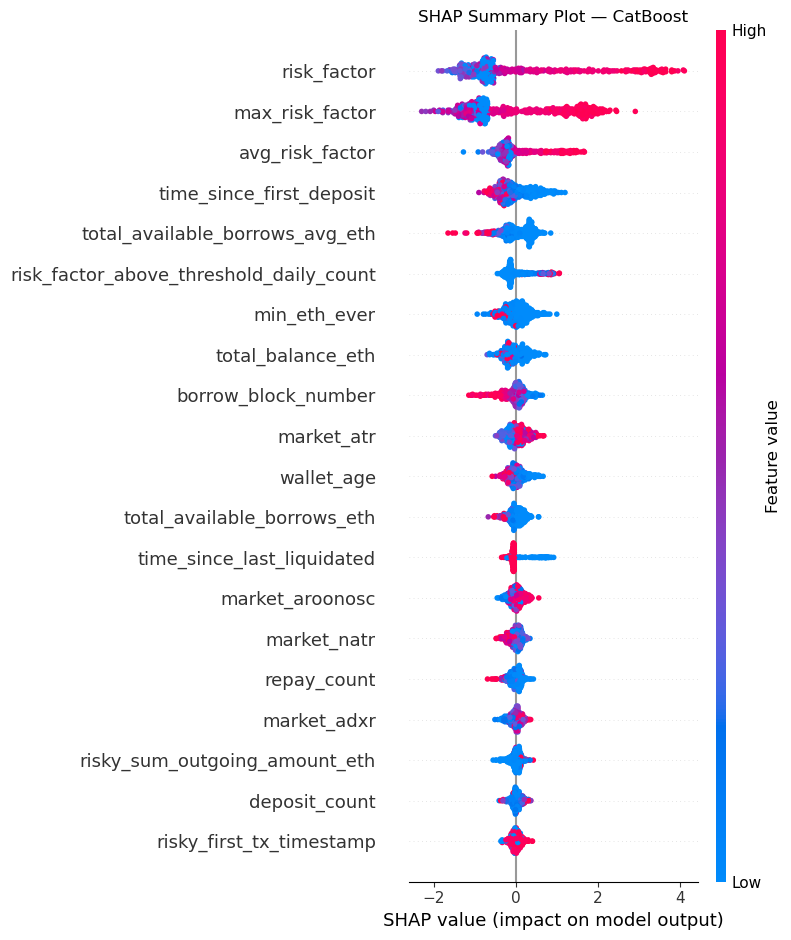

In [17]:
import shap
import matplotlib.pyplot as plt

# 🔹 Ограничим количество объектов (если нужно)
X_val_sample = X_val.sample(n=500, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

# 🔹 Создание Pool для CatBoost
pool = Pool(X_val_sample, y_val_sample)

# 🔹 Получение SHAP-значений
print("🔍 Вычисляем SHAP для CatBoost...")
shap_values = best_model.get_feature_importance(pool, type='ShapValues', verbose=True)

# 🔹 Последняя колонка — base value, удаляем её
shap_values_only = shap_values[:, :-1]

# 🔹 Построение графика
shap.summary_plot(shap_values_only, X_val_sample, show=False)
plt.title("SHAP Summary Plot — CatBoost")
plt.tight_layout()
plt.savefig("shap_summary_catboost.png")
plt.show()


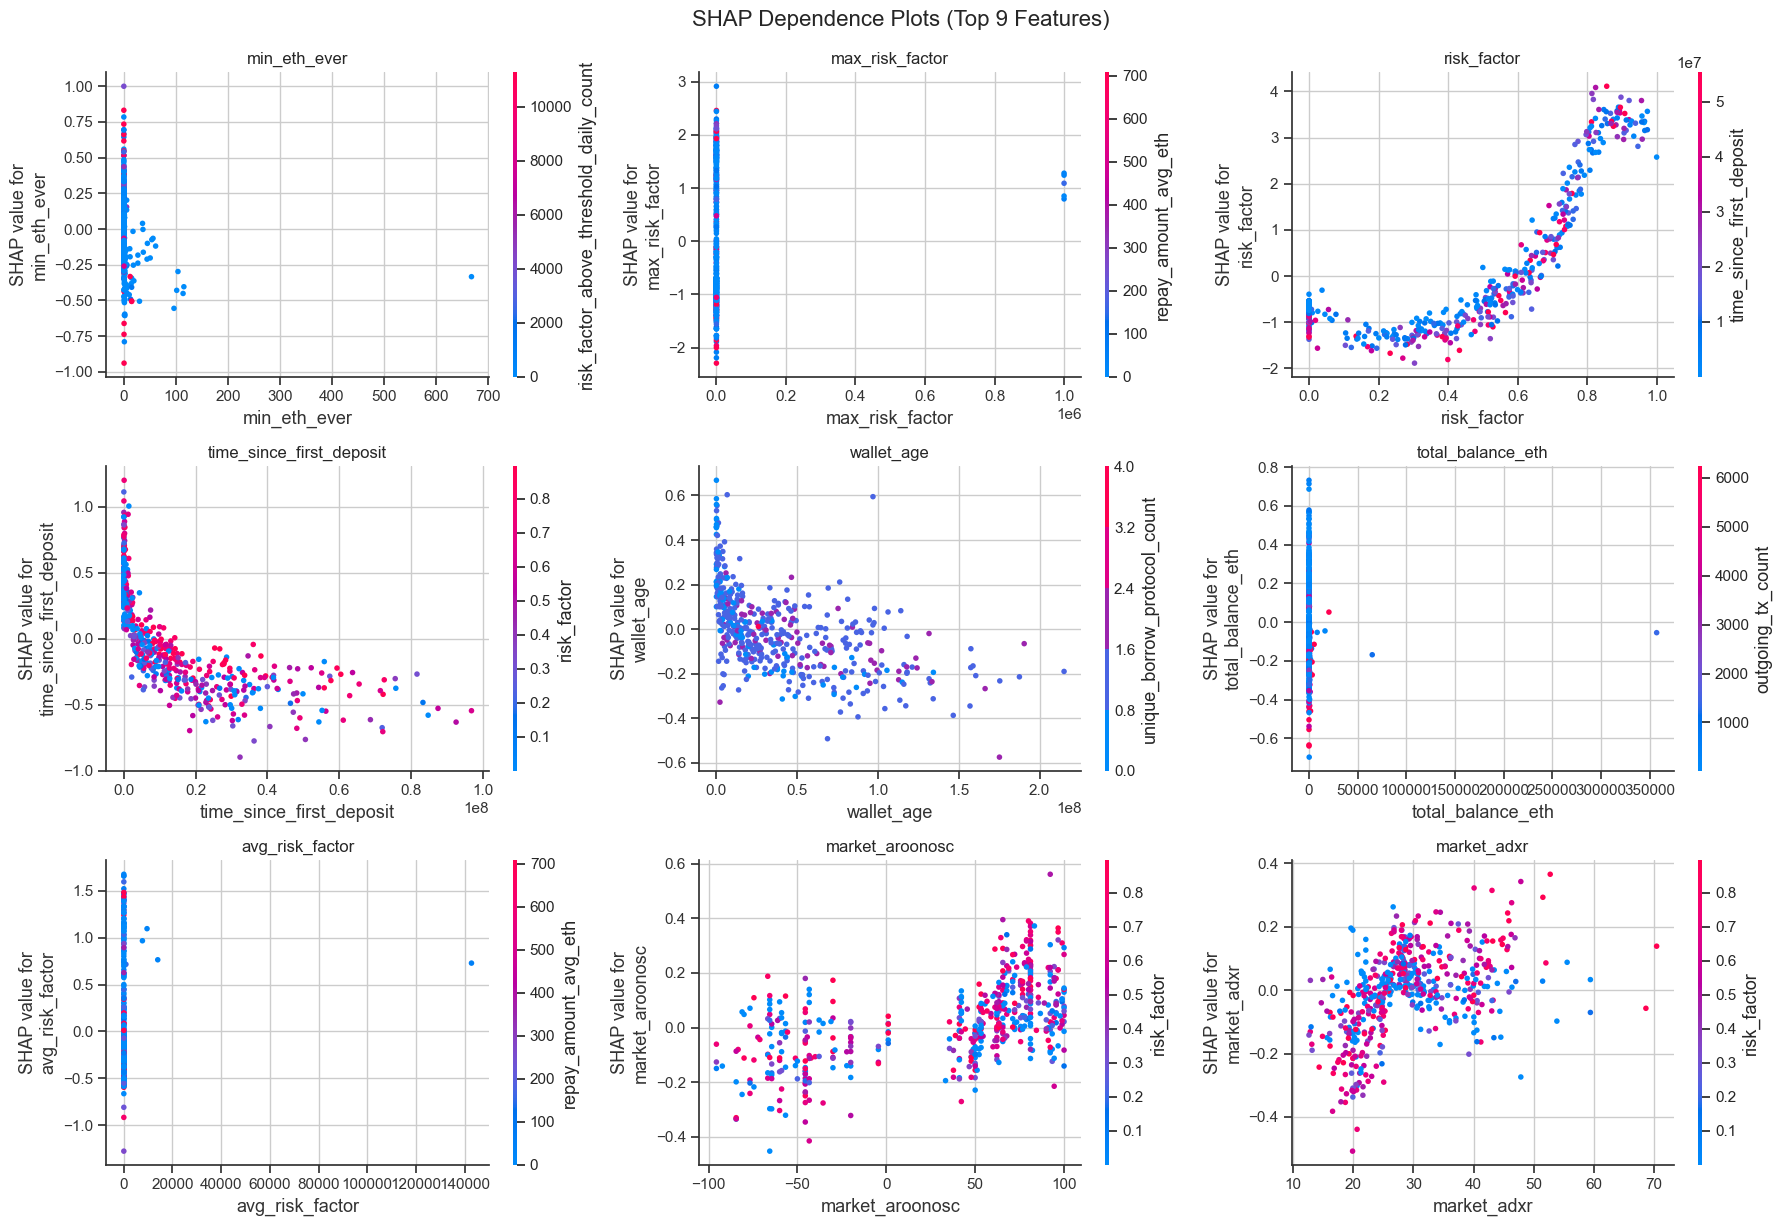

In [20]:
import seaborn as sns
# 9 топовых признаков
top_features = feature_importance_df["feature"].head(9).tolist()

# Установим стиль seaborn
sns.set(style="whitegrid")

# Рисуем 3x3 графика
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    plt.sca(axes[i])  # Активируем i-й subplot
    shap.dependence_plot(
        feature,
        shap_values_only,
        X_val_sample,
        show=False,
        ax=axes[i]
    )
    axes[i].set_title(feature)

# # Удалим пустые subplot-ы (если они есть)
# for j in range(len(top_features), 9):
#     fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("SHAP Dependence Plots (Top 9 Features)", fontsize=16, y=1.02)
plt.show()

In [21]:
top_features

['min_eth_ever',
 'max_risk_factor',
 'risk_factor',
 'time_since_first_deposit',
 'wallet_age',
 'total_balance_eth',
 'avg_risk_factor',
 'market_aroonosc',
 'market_adxr']

## Интерпретация
* С увеличение `risk_factor`, увеличивается вероятность принадлежать к классу 1
* С увеличение `time_since_first_deposit`, уменьшается вероятность принадлежать к классу 1
* С увеличение `wallet_age`, уменьшается вероятность принадлежать к классу 1
* Увеличение `market_adxr`, незначительно увеличивает вероятность принадлежать к классу 1